<font size=7> HC328 base Buzsaki Latencies 2

# Import stuff, get data

I attempt to get Sury's code for analyzing connectivity working.

In [2]:
from scipy.ndimage import gaussian_filter1d

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy import signal
import math
from scipy.sparse import csr_array
import random

import pickle
from human_hip.spike_data import curate_latencies, plot_raster_latency_pairs, plot_vector_layout, read_phy_files,\
                                  plot_latency_dist_hist, plot_latency_angle_hist
from human_hip.animate import animate_latencies
from human_hip import spike_data

In [4]:

import warnings
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint
import diptest 
from ipywidgets import interact_manual, interact


In [5]:
with open("/workspaces/human_hippocampus/data/ephys/2023-04-02-e-hc328_unperturbed/sd_ca1_curated.pkl", "rb") as filename:
    sd = pickle.load(filename)

# <font color="grey"> Helper Code


Code is adapted from `latencies.py` in the `src` folder

## <font color="grey"> latencies

In [6]:

import numpy as np
from scipy.signal import correlate, correlation_lags



def latencies(neuron1, neuron2, sd, ms_cutoff_low=0, ms_cutoff_high=20 ):
    """
    Function:
        returns all the latencies that occur between two neurons, n1 and n2. 
        A latency is defined as the time difference between a spike from n1 and the nearest spike from n2 (positive or negative)
    Inputs:
        neuron1 (integer): index of the neuron, n1 
        neuron2 (integer): index of the neuron, n2, *note* if n1 occurs before n2, the latency will be positive
        sd (SpikeData object): contains the original spike data from the recording
        ms_cutoff (integer): the maximum latency to be considered, in milliseconds
    Outputs:
        cur_latencies (np.array): the time difference between n1 and n2, for ever latency occurence less than ms_cutoff
    """
    train1 = sd.train[ neuron1 ]
    train2 = sd.train[ neuron2 ]    
    cur_latencies = []
    for time in train1:
        abs_diff_ind = np.argmin(np.abs(train2 - time))  # Subtract time from all spikes in the train and take the absolute value        
        latency = np.array(train2)-time       # Calculate the actual latency
        latency = latency[abs_diff_ind]

        if np.abs(latency) <= ms_cutoff_high and np.abs(latency) >= ms_cutoff_low : # Only append latencies within a certain time cutoff
            cur_latencies.append(latency)
    return np.array(cur_latencies)



## <font color="grey"> Cross Sttc

<font color="orange">I change the original code to calculate the cross sttc from -50-50ms instead of -1000-1000ms. This is done to speed up the calculation.

In [7]:

def cross_sttc( n1, n2, sd, delt=20 ):
    """
    Function: Calculates the cross correlation from -1000ms to 1000ms, expcept using the spike time tiling coefficient, between two neurons, n1 and n2
    Inputs:
        n1 (integer): index of the neuron, n1 
        n2 (integer): index of the neuron, n2
        sd (SpikeData object): contains the original spike data from the recording
        delt (integer): the time window to calculate the spike time tiling coefficient over
    Outputs:
        sttc (float): the spike time tiling coefficient for each shift between n1 and n2
    """
    assert len(sd.neuron_data[0]) == len(sd.train) 
    sttcs = []
    for i in range(-30,31):
        sd.train.append( sd.train[n1]+i )
        sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )
        sd.train.pop(-1)
    return np.array(sttcs)


## <font color="grey"> Cross Correlation

In [8]:

def correlation(x, y):
    """
    Function: Calculates the correlation between two lists
    Inputs:
        x (list): first list
        y (list): second list
    Outputs:
        (float): correlation between x and y
    """
    shortest = min( len(x), len(y) )
    return np.corrcoef(x[:shortest], y[:shortest])[0, 1]


## <font color="grey">Poission Probability <small> Sury Code

Probability of computing n or more event given lambda_

<font color="orange"> I have to still check that Sury's code is correct

In [9]:
def p_fast(n, lambda_):
    """
    A poisson estimation of the probability of observing n or more events
    """
    ## take log to make sure the factorial does not overflow
    # add poisson_var when x = 0, 1, take log after calculation to avoid log(0)
    if n > 1:
        poisson_01 = [np.exp(-lambda_)*lambda_**x/math.factorial(x) for x in [0, 1]]
        poisson_res = [np.exp(-lambda_ + x*math.log(lambda_) - math.log(math.factorial(x))) for x in range(2, n)]
        poisson_var = poisson_01 + poisson_res
    else:
        poisson_var = [np.exp(-lambda_)*lambda_**x/math.factorial(x) for x in range(n)]
    continuity_correction = np.exp((math.log(0.5) - lambda_ + n*math.log(lambda_)) - math.log(math.factorial(n)))
    return 1 - np.sum(poisson_var) - continuity_correction


## <font color="grey"> Plot Pair Analysis

In [10]:
import warnings
from human_hip.spike_data import latencies, latency_times, plot_raster, plot_footprint
import diptest 
from ipywidgets import interact_manual, interact

def plot_pair_analysis( n1, n2, sd):
    
    lag = np.median(latencies( n1, n2, sd))
    if lag<0:
        start_i = n2
        end_i = n1
    else:
        start_i = n1
        end_i = n2

    # Layout Plot
    warnings.filterwarnings("ignore")
    plot_footprint( sd, [start_i, end_i] )
    
    # Summary Stats
    latencies_raw = latencies( start_i, end_i, sd, ms_cutoff_high=10  )
    latencies_clean = latencies_raw
    #latencies_clean = latencies_raw[ np.where( np.abs(latencies_raw) < 15 )[0] ]
    

    
    
    print( "Number of Latencies", len(latencies_clean) )
    print( "Mean Latency", round(np.mean(latencies_clean), 3) )
    print( "Median Latency", round(np.median(latencies_clean), 3) )
    #print( "Latency Probability", {round(100*(len(lates_filtered)/len(lates_raw)))})
    print("STTC", sd.spike_time_tiling( start_i, end_i) )
    print("Diptest P-val", round( diptest.diptest(latencies_clean)[1] , 3) )
    print( "Latency Probability", round(len(latencies_clean)/len(latencies_raw), 3) )
    print(".")
    print( "Sender Neuron", start_i)
    print( "Sender   Firing Rate", round(sd.rates(unit='Hz')[start_i] , 3) )
    print(".")
    print("Receiver Neuron", end_i)
    print( "Receiver Firing Rate", round(sd.rates(unit='Hz')[end_i], 3) )
    
    # Plot other graphs
    figs, plots = plt.subplots(nrows=3,ncols=2,figsize=(14,10))

    mean_latency = np.mean(latencies_clean)     # Get mean and SD
    std_latency = np.std(latencies_clean)
    cutoff = 2 * std_latency           # remove outliers
    lates_filtered = [latency for latency in latencies_clean if abs(latency - mean_latency) <= cutoff]
    plots[0,0].hist(lates_filtered, bins=12, alpha=0.7, label='Latency')
    plots[0,0].axvline(mean_latency, color='red', linestyle='dashed', linewidth=2, label='Mean')
    plots[0,0].axvline(mean_latency - std_latency, color='green', linestyle='dashed', linewidth=2, label='Std -')
    plots[0,0].axvline(mean_latency + std_latency, color='green', linestyle='dashed', linewidth=2, label='Std +')
    plots[0,0].axvline(0, color='black', linestyle='dashed', linewidth=0.5, label='Std +')
    plots[0,0].set_xlim(-1*(abs(mean_latency)+cutoff), abs(mean_latency) + cutoff) 
    plots[0,0].set_xlabel("Latency (ms)")
    plots[0,0].set_ylabel("Count")
    plots[0,0].set_title(f"Fancy Latency Histogram")
    plots[0,0].legend()

    plots[0,1].hist(latencies_clean, bins=12)
    plots[0,1].set_title("Latency Histogram")
    plots[0,1].set_xlabel("Latency (ms)")
    plots[0,1].set_ylabel("Count")

    # isi = sd.interspike_intervals()[start_i]
    # plots[1,0].hist( isi[ isi<200 ], bins=50);
    # plots[1,0].set_title("Sender ISI")
    # plots[1,0].set_xlabel("Time bin(ms)")
    # plots[1,0].set_ylabel("ISI count")

    # isi = sd.interspike_intervals()[end_i]
    # plots[1,1].hist( isi[ isi<200 ] , bins=50);
    # plots[1,1].set_title("Receiver ISI")
    # plots[1,1].set_xlabel("Time bin(ms)")
    # plots[1,1].set_ylabel("ISI count")
    
    
    # plots[2,0].plot( sd.neuron_data[0][start_i]["template"] )
    # plots[2,0].set_title("Sender Spike Waveform")
    # plots[2,0].set_xlabel("")
    # plots[2,0].set_ylabel("")
    
    # plots[2,1].plot( sd.neuron_data[0][end_i]["template"] )
    # plots[2,1].set_title("Receiver Spike Waveform")
    # plots[2,1].set_xlabel("")
    # plots[2,1].set_ylabel("")



## <font color="grey"> Plot Histogram

In [11]:
def pairs_hisogram(pairs, sd, ms_cutoff_high=15):
    @interact
    def plot_pair(pair = (0, len(pairs)-1) ):
        latencies_pair = latencies( pairs[pair,0], pairs[pair,1], sd, ms_cutoff_high=20  )
        plt.xlim(-ms_cutoff_high, ms_cutoff_high)
        plt.hist(latencies_pair, bins=12)

# <font color="magenta"> Busaki 2 & 1.5ms Latency Cutoff for 15ms window

In [28]:
sttc_cutoff = 0.04
sttc_delta=20 

# Get all latencies whose STTC is above some minimum STTC cuttoff
print(sd.N**2 , "Starting Pairs")
sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
for i in range(sd.N):
    for j in range(i+1,sd.N):
        if sttc_neo[i,j] > sttc_cutoff:
            pairs.append([i,j])
print( len(pairs), "pairs above sttc cutoff")



# Get all latencies whose median latency is above some minimum Latency Cuttoff
pairs_late = [] #lags_late = []
for pair in pairs:
    pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=15)  #latency= np.median(pair_latencies)
    if  abs(np.mean(pair_latencies))> 1.5 and len(pair_latencies)>20: #abs(np.median(pair_latencies))> 1 and
        if np.mean(pair_latencies) < 0:
            pairs_late.append( [pair[1], pair[0]] )  #lags_late.append( latency )
        else:
            pairs_late.append( pair )
pairs = np.array(pairs_late)
print( len(pairs_late), "pairs above latencency cutoff")


18496 Starting Pairs
567 pairs above sttc cutoff
92 pairs above latencency cutoff


In [29]:
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=8

pairs_pois = []
pvals = []
for pair in pairs:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)
    if p_val < 0.0005:
        pairs_pois.append( pair )
        pvals.append( p_val )
pairs = np.array(pairs_pois)
print( len(pairs), "pairs above buzsaki")

/tmp/ipykernel_17740/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_17740/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


64 pairs above buzsaki


In [15]:
pairs_hisogram(pairs, sd,  ms_cutoff_high=15 )

interactive(children=(IntSlider(value=31, description='pair', max=63), Output()), _dom_classes=('widget-intera…

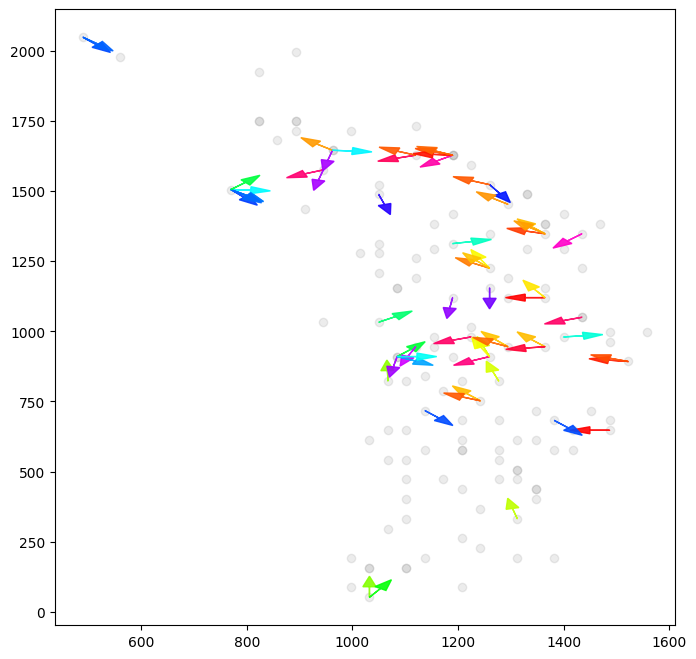

In [16]:
plot_vector_layout( sd, pairs)  

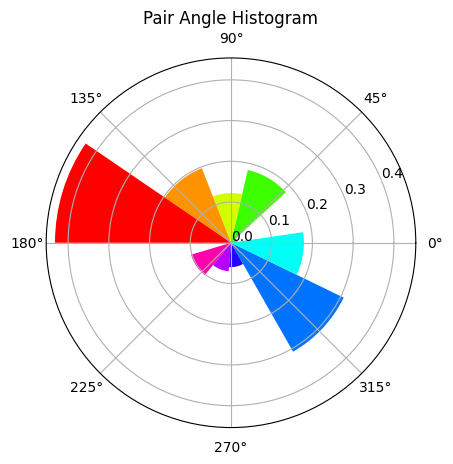

In [17]:
plot_latency_angle_hist(sd, pairs , by_firing_rate=True)

# <font color="blue"> ??? with latency window of ??? 

In [13]:
sttc_cutoff = 0.04
sttc_delta=20 

# Get all latencies whose STTC is above some minimum STTC cuttoff
print(sd.N**2 , "Starting Pairs")
sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
for i in range(sd.N):
    for j in range(i+1,sd.N):
        if sttc_neo[i,j] > sttc_cutoff:
            pairs.append([i,j])
print( len(pairs), "pairs above sttc cutoff")



# Get all latencies whose median latency is above some minimum Latency Cuttoff
pairs_late = [] #lags_late = []
for pair in pairs:
    pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=15)  #latency= np.median(pair_latencies)
    if  abs(np.median(pair_latencies))> 1.5 and len(pair_latencies)>20: #abs(np.median(pair_latencies))> 1 and
        if np.median(pair_latencies) < 0:
            pairs_late.append( [pair[1], pair[0]] )  #lags_late.append( latency )
        else:
            pairs_late.append( pair )
pairs = np.array(pairs_late)
print( len(pairs_late), "pairs above latencency cutoff")


18496 Starting Pairs
567 pairs above sttc cutoff
144 pairs above latencency cutoff


In [16]:
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=8

pairs_pois = []
pvals = []
for pair in pairs:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)
    if p_val < 0.0005:
        pairs_pois.append( pair )
        pvals.append( p_val )
pairs = np.array(pairs_pois)
print( len(pairs), "pairs above buzsaki")

/tmp/ipykernel_56729/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_56729/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


101 pairs above buzsaki


In [17]:
pairs_hisogram(pairs, sd,  ms_cutoff_high=15 )

interactive(children=(IntSlider(value=50, description='pair'), Output()), _dom_classes=('widget-interact',))

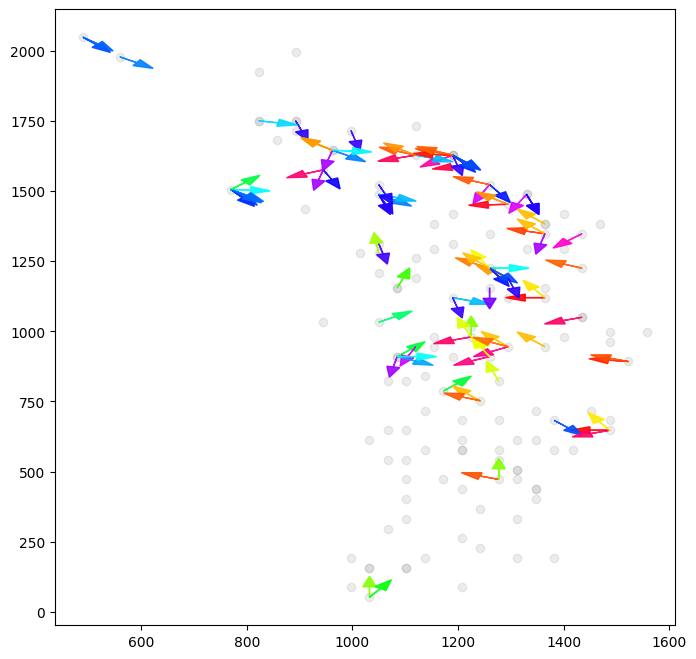

In [18]:
plot_vector_layout( sd, pairs)  

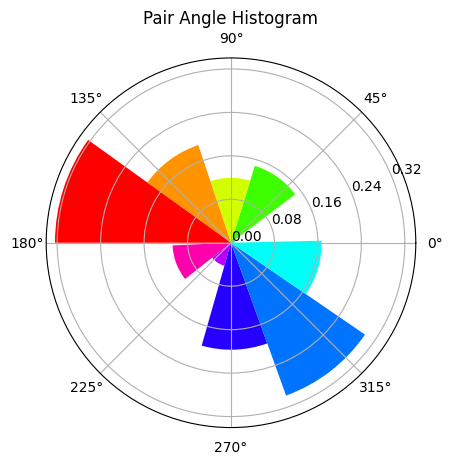

In [19]:
plot_latency_angle_hist(sd, pairs , by_firing_rate=True)

# <font color="purple"> Buszaki P-Vals

In [46]:

# Get all latencies whose STTC is above some minimum STTC cuttoff
print(sd.N**2 , "Starting Pairs")
sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
for i in range(sd.N):
    for j in range(i+1,sd.N):
        if sttc_neo[i,j] > sttc_cutoff:
            pairs.append([i,j])
print( len(pairs), "pairs above sttc cutoff")

# Get all latencies whose median latency is above some minimum Latency Cuttoff
pairs_late = [] #lags_late = []
for pair in pairs:
    pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=20)  #latency= np.median(pair_latencies)
    if abs(np.median(pair_latencies))> 1:
        pairs_late.append( pair )  #lags_late.append( latency )
pairs= pairs_late
print( len(pairs_late), "pairs above latencency cutoff")

18496 Starting Pairs
567 pairs above sttc cutoff
360 pairs above latencency cutoff


In [47]:
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=8

pairs_pois = []
pvals = []
for pair in pairs:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)
    if p_val < 0.0005:
        pairs_pois.append( pair )
        pvals.append( p_val )
pairs = np.array(pairs_pois)
print( len(pairs), "pairs above buzsaki")

/tmp/ipykernel_56729/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_56729/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


167 pairs above buzsaki


In [48]:
pvals=np.array(pvals)
pairs_pois = np.array(pairs_pois)
pairs_pois2 = pairs_pois[pvals < 1e-11]
len(pairs_pois2)

50

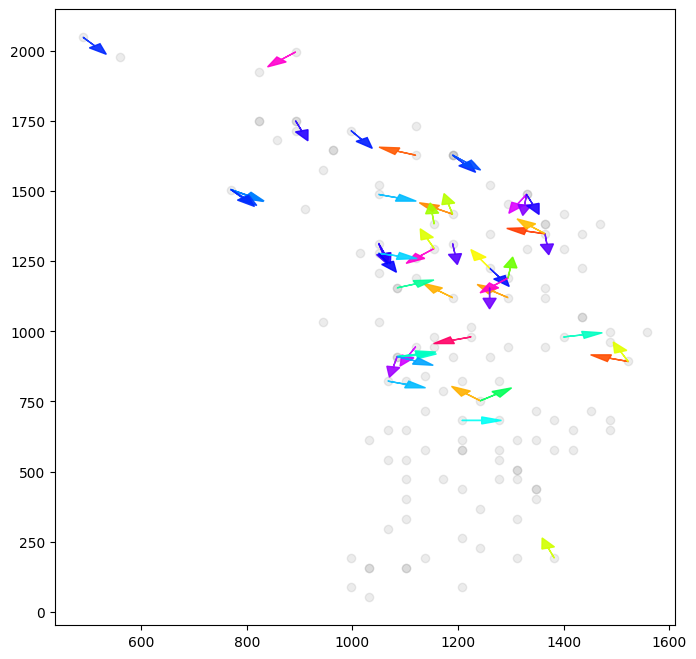

In [49]:
plot_vector_layout( sd, pairs_pois2)  

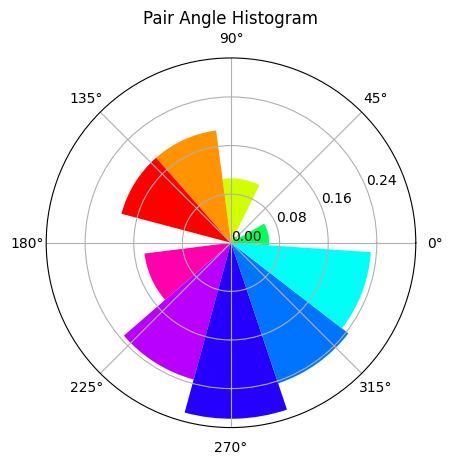

In [51]:
plot_latency_angle_hist(sd, pairs_pois2 , by_firing_rate=True)

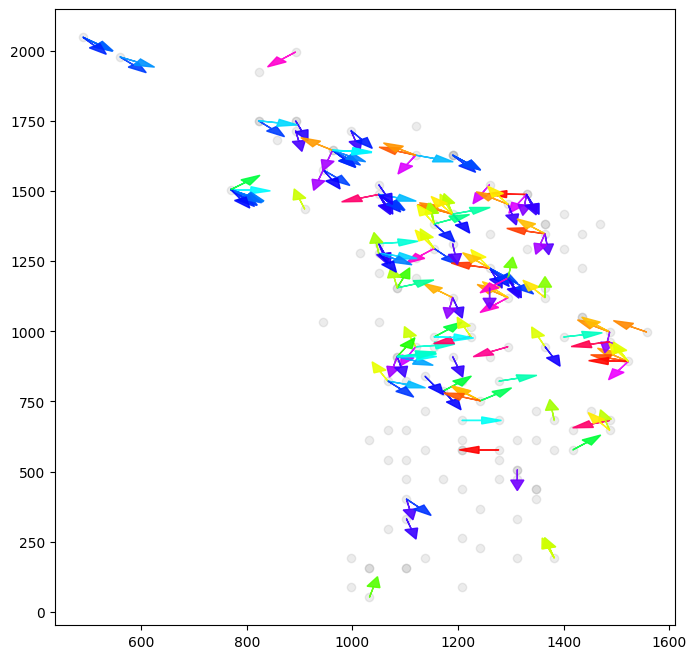

In [42]:
plot_vector_layout( sd, pairs)  

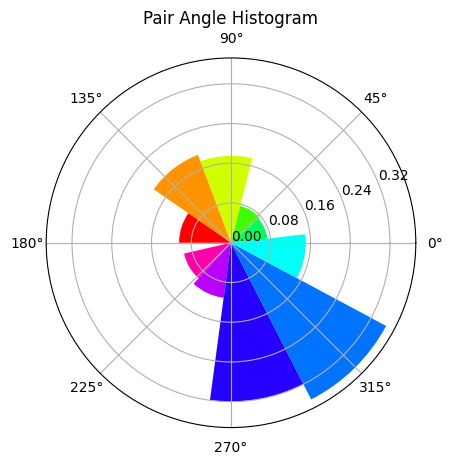

In [45]:
plot_latency_angle_hist(sd, pairs , by_firing_rate=True)

# Initial Curation

code is from `curate_latencies` function

In [8]:

sttc_cutoff = 0.04
latency_cutoff=1
sttc_delta=20 

# Get all latencies whose STTC is above some minimum STTC cuttoff
print(sd.N**2 , "Starting Pairs")
sttc_neo = sd.spike_time_tilings( sttc_delta )    # sttc matrix   
pairs = []                            # get list (without duplicates) of all pairs above cutoff (excluding diagonal)
for i in range(sd.N):
    for j in range(i+1,sd.N):
        if sttc_neo[i,j] > sttc_cutoff:
            pairs.append([i,j])
print( len(pairs), "pairs above sttc cutoff")

# Get all latencies whose median latency is above some minimum Latency Cuttoff
pairs_late = [] #lags_late = []
for pair in pairs:
    pair_latencies = latencies( pair[0], pair[1], sd, ms_cutoff_high=20)  #latency= np.median(pair_latencies)
    if abs(np.median(pair_latencies))> latency_cutoff and len(pair_latencies)>20:
        if np.median(pair_latencies) < 0:
            pairs_late.append( [pair[1], pair[0]] )  #lags_late.append( latency )
        else:
            pairs_late.append( pair )
pairs= pairs_late
print( len(pairs_late), "pairs above latencency cutoff")





2601 Starting Pairs
567 pairs above sttc cutoff
161 pairs above latencency cutoff


In [10]:
#pickle.dump( pairs, open( "sanity_20minlates.pkl", "wb" ) )
#pairs = pickle.load( open( "sanity_20minlates.pkl", "rb" ) )

# Buzsaki Method

<font color="orange"> Original paper only considered lags between 0.8-2.8ms. We consider broader range

<font color="red"> Start by doing function for 1 pair

In [13]:
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=8

pairs_pois = []
pvals = []
for pair in pairs:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)
    if p_val < 0.0005:
        pairs_pois.append( pair )
        pvals.append( p_val )
pairs_pois = np.array(pairs_pois)

/tmp/ipykernel_4778/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_4778/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


In [11]:
len(pairs_pois)
#pairs_pois

115

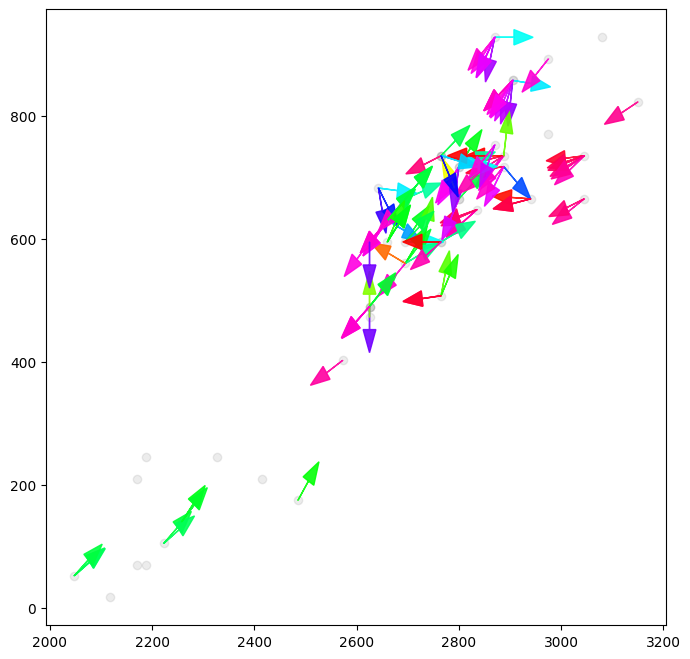

In [12]:
plot_vector_layout( sd, pairs_pois )

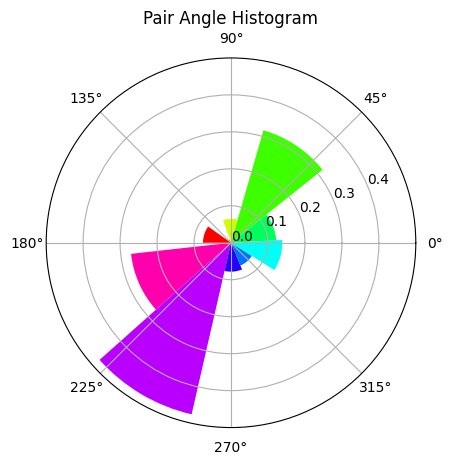

In [20]:
plot_latency_angle_hist(sd, pairs_pois , by_firing_rate=True)

# Buzsaki 2

get smallest p-values

In [ ]:
# plt.hist(pvals, bins=100)
# plt.xlim(0,.0001)

In [14]:
pvals = np.array(pvals)

In [15]:
len(pvals[pvals<0.0005])

115

In [21]:
pvals

array([9.06882476e-13, 1.22268698e-09, 1.29278010e-07, 6.20192655e-05,
       8.37430633e-10, 7.68563628e-08, 2.65872013e-14, 3.87308053e-10,
       1.77806830e-07, 3.11285588e-07, 8.63981552e-12, 4.95082496e-04,
       1.50340786e-11, 2.12504562e-07, 1.16850154e-05, 1.12291764e-10,
       2.93392803e-13, 4.49029825e-12, 6.02888599e-11, 7.07721390e-10,
       1.73476647e-06, 2.60694167e-05, 3.81477177e-07, 1.68160232e-09,
       5.17770221e-06, 4.43140635e-05, 2.67150137e-09, 2.05821848e-11,
       3.47590340e-04, 3.39329169e-10, 2.81115627e-09, 6.30581790e-13,
       1.96938138e-12, 3.40724577e-05, 1.51015575e-11, 6.20908041e-08,
       1.28971922e-12, 4.60483850e-04, 3.39812910e-13, 3.46549717e-08,
       4.21961585e-08, 2.03591793e-07, 1.78931089e-11, 4.21187431e-07,
       1.79047812e-11, 4.32800668e-08, 4.17275246e-05, 1.37754596e-07,
       1.42898870e-06, 4.06932579e-05, 7.51117454e-09, 8.24155724e-08,
       8.38998232e-13, 2.16347983e-13, 6.16038134e-08, 1.87155237e-05,
      

In [23]:
sum(np.array(pvals) < 1e-10) 

41

In [24]:
pairs_pois2 = pairs_pois[pvals < 1e-10]

In [25]:
len(pairs_pois2)

41

In [32]:
@interact_manual
def plot_pair(pair = (0, len(pairs_pois2)) ):
    plot_pair_analysis( pairs_pois2[pair,0], pairs_pois2[pair,1], sd )


interactive(children=(IntSlider(value=20, description='pair', max=41), Button(description='Run Interact', styl…

In [ ]:
len(pairs_pois)
len(pvals)

3064

In [ ]:
pairs_pois2

array([[  0,  18],
       [  0,  78],
       [210,   0],
       [ 19,   2],
       [ 46,   2],
       [ 63,   2],
       [135,   2],
       [155,   2],
       [  2, 189],
       [136,   3],
       [  3, 166],
       [  3, 170],
       [  4,  96],
       [122,   4],
       [183,   4],
       [191,   4],
       [  5,  88],
       [  6,  30],
       [ 50,   6],
       [  6, 105],
       [109,   6],
       [  6, 115],
       [  6, 163],
       [178,   6],
       [  6, 204],
       [  7,   8],
       [ 26,   7],
       [ 45,   7],
       [104,   7],
       [151,   7],
       [152,   7],
       [160,   7],
       [182,   7],
       [ 59,   8],
       [  8, 159],
       [  9,  47],
       [  9, 186],
       [ 10, 158],
       [ 11, 115],
       [ 39,  13],
       [ 70,  13],
       [157,  13],
       [186,  13],
       [ 14, 101],
       [133,  14],
       [150,  14],
       [170,  14],
       [ 14, 173],
       [185,  14],
       [190,  14],
       [ 26,  15],
       [ 28,  15],
       [ 38,

In [ ]:
to_keep = random.sample(range(len(pairs_pois2)), 200)

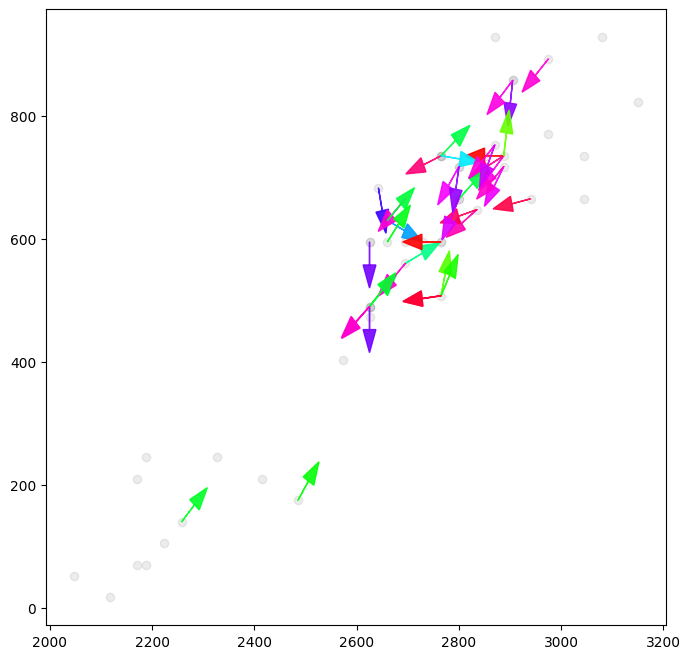

In [33]:
plot_vector_layout( sd, pairs_pois2)

In [ ]:
range(len(pairs_pois2))

In [ ]:
@interact_manual
def plot_pair(pair = range(len(pairs_pois2)) ):
    plot_pair_analysis( pairs_pois2[pair,0], pairs_pois2[pair,1], sd )


interactive(children=(Dropdown(description='pair', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, …

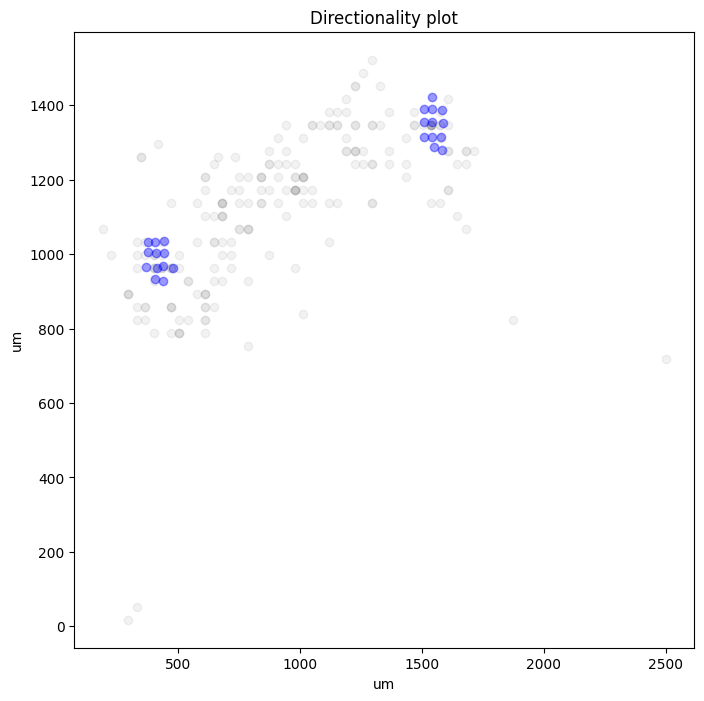

Number of Latencies 240
Mean Latency 0.599
Median Latency 1.25
STTC 0.0440837980757793
Diptest P-val 0.839
Latency Probability 1.0
.
Sender Neuron 46
Sender   Firing Rate 2.627
.
Receiver Neuron 2
Receiver Firing Rate 5.56


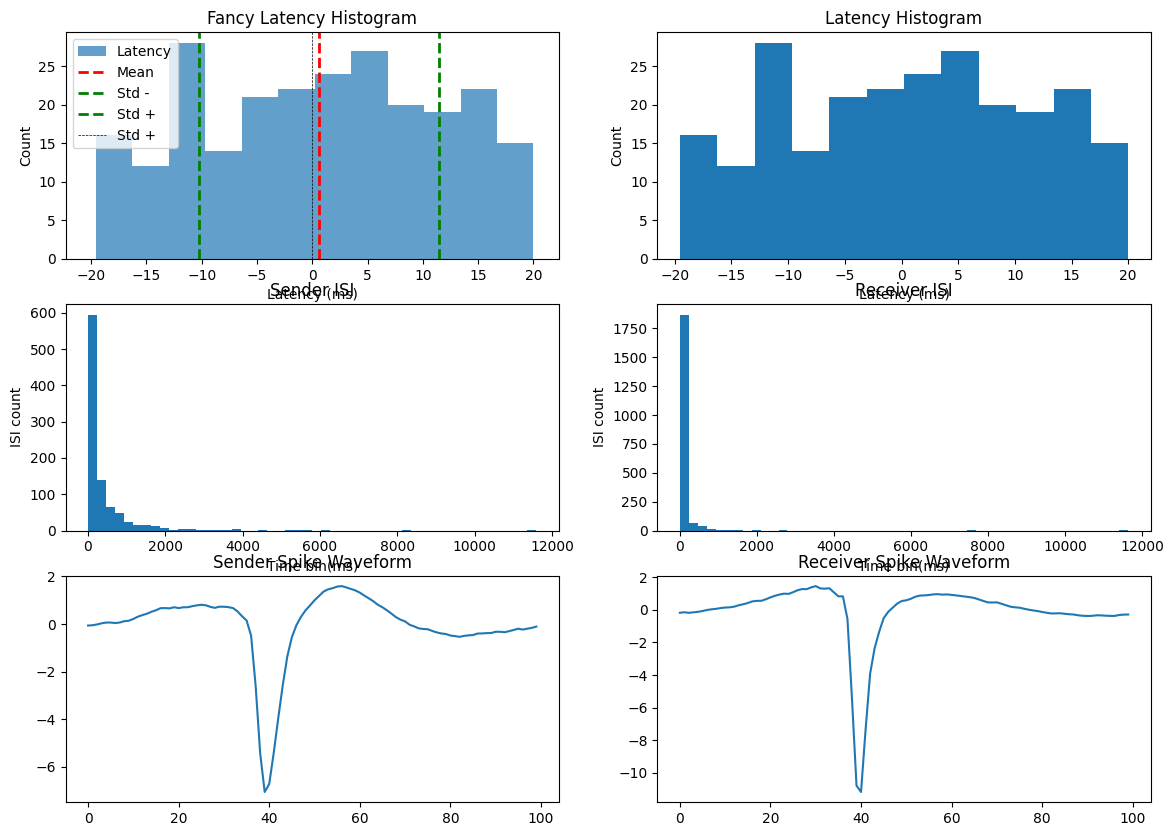

In [ ]:
plot_pair_analysis( 46, 2, sd )

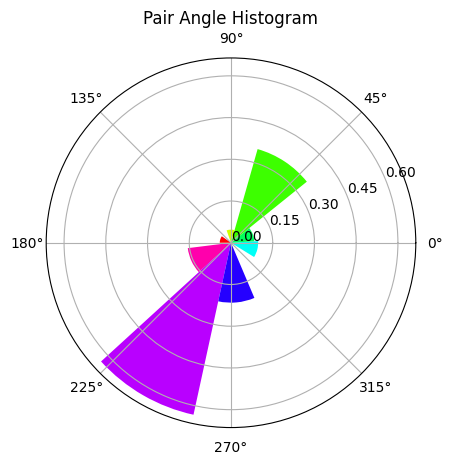

In [34]:
plot_latency_angle_hist(sd, pairs_pois2 , by_firing_rate=True)

# Buzsaki - Anticausal

In [27]:
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=8

In [28]:
pairs = pairs_pois
pairs_pois = []
for pair in pairs:
    sttcs = cross_sttc( pair[0], pair[1], sd, delt=sttc_delta ) 
    sttcs_smth = gaussian_filter1d(sttcs, sigma=10)  

    sttcs_cutoff = sttcs[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(sttcs_cutoff == np.amax(sttcs_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = sttcs_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)

    anti_sttcs_cutoff = sttcs[30-cross_sttc_max_cutoff:30-cross_sttc_min_cutoff]
    max_arg_cutoff = np.argwhere(anti_sttcs_cutoff == np.amax(anti_sttcs_cutoff))[0][-1] 
    max_arg = max_arg_cutoff+30-cross_sttc_max_cutoff
    pois_lambda = sttcs_smth[max_arg]
    anti_p_val = p_fast(pois_n, pois_lambda)

    if p_val < 0.0005 and anti_p_val<0.0005:
        pairs_pois.append( pair )
pairs_pois = np.array(pairs_pois)

/tmp/ipykernel_56729/1247081216.py:12: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  assert len(sd.neuron_data[0]) == len(sd.train)
/tmp/ipykernel_56729/1247081216.py:16: DeprecationWarning: Call to deprecated function (or staticmethod) neuron_data. (Use NeuronAttributes instead of neuron_data, with the function load_spike_data())
  sttcs.append( sd.spike_time_tiling( len(sd.neuron_data[0]) , n2, delt= delt) )


In [29]:
len(pairs_pois)

164

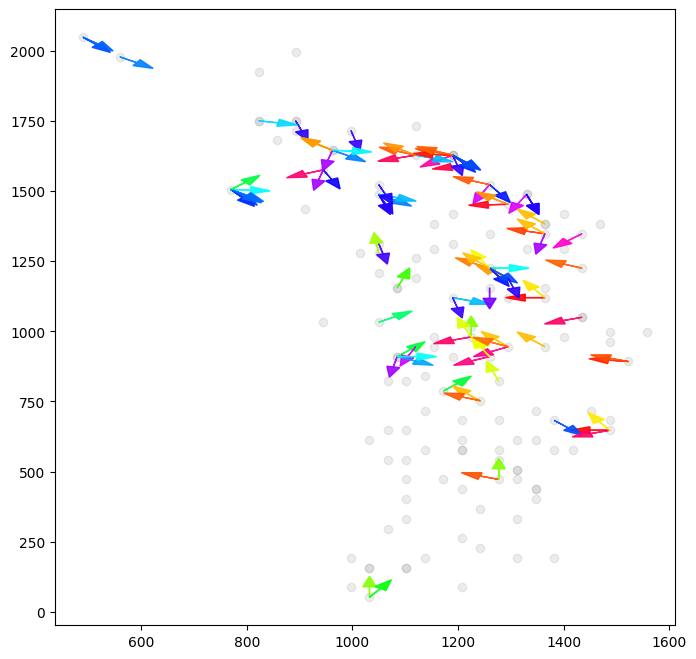

In [23]:
plot_vector_layout( sd, pairs_pois)

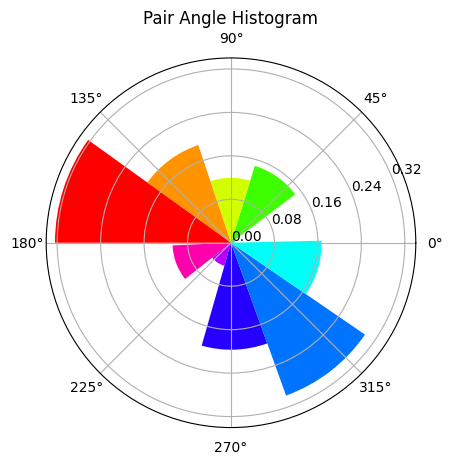

In [24]:
plot_latency_angle_hist(sd, pairs_pois , by_firing_rate=True)

# <font color="aqua"> Buszaki with Pearson Correlation

In [91]:
len(pairs)

360

<font color="green"> Code to change

In [89]:
smoothness = 1
cross_sttc_min_cutoff=1
cross_sttc_max_cutoff=4

In [94]:
pairs_pois = []
for pair in pairs:

    correlations = []
    n2 = np.zeros( int(sd.length)+ 31 )
    n2[ np.round(sd.train[pair[1]]).astype(int) ] = 1
    if smoothness:
        n2 = gaussian_filter1d(n2, sigma=smoothness)  
    for i in range(-30,31):
        n1 = np.zeros( int(sd.length)+ 31 )
        n1[ np.round(sd.train[pair[0]]+i).astype(int) ] = 1
        if smoothness:
            n1 = gaussian_filter1d(n1, sigma=1) 
        correlations.append( np.corrcoef( n1, n2 )[0, 1] )
    correlations_smth = gaussian_filter1d(correlations, sigma=10)

    correlations_cutoff = correlations[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
    max_arg_cutoff = np.argwhere(correlations_cutoff == np.amax(correlations_cutoff))[0][0] 
    pois_n = max_arg_cutoff+cross_sttc_min_cutoff
    max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
    pois_lambda = correlations_smth[max_arg]
    p_val = p_fast(pois_n, pois_lambda)
    if p_val < 0.01:
        pairs_pois.append( pair )
        
pairs_pois = np.array(pairs_pois)

ValueError: math domain error

<font color="red"> Start with one pair to figure out cross correlation

In [53]:
pair = pairs[0]
#sd.train
#max(sd.train[0])

In [98]:
len(pairs_pois)

262

In [77]:
correlations = []
n2 = np.zeros( int(sd.length) )
n2[ np.round(sd.train[pair[1]]).astype(int) ] = 1
#n2 = gaussian_filter1d(n2, sigma=2)  
n2 = gaussian_filter1d(n2, sigma=1)  


for i in range(-30,31):
    n1 = np.zeros( int(sd.length) )
    n1[ np.round(sd.train[pair[0]]+i).astype(int) ] = 1
    #n1 = gaussian_filter1d(n1, sigma=2)  
    n1 = gaussian_filter1d(n1, sigma=1) 
    correlations.append( np.corrcoef( n1, n2 )[0, 1] )



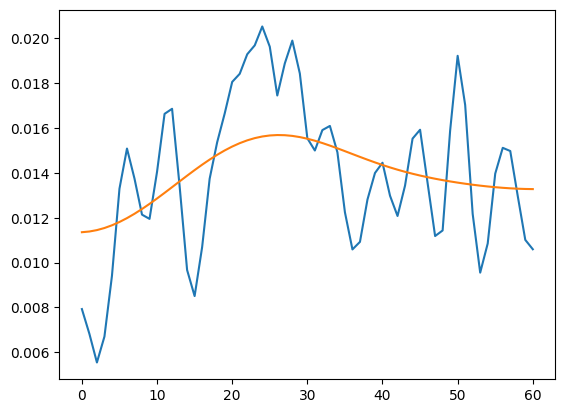

In [78]:
plt.plot(correlations)
correlations_smth = gaussian_filter1d(correlations, sigma=10) 
plt.plot(correlations_smth)

In [79]:
correlations_cutoff = correlations[30+cross_sttc_min_cutoff:30+cross_sttc_max_cutoff]
max_arg_cutoff = np.argwhere(correlations_cutoff == np.amax(correlations_cutoff))[0][0] 
pois_n = max_arg_cutoff+cross_sttc_min_cutoff
max_arg = max_arg_cutoff+30+cross_sttc_min_cutoff
pois_lambda = correlations_smth[max_arg]
p_val = p_fast(pois_n, pois_lambda)
#if p_val < 0.0005:
#    pairs_pois.append( pair )



In [80]:
p_val

2.91377279813213e-07

In [30]:
sd_raster =  sd.raster(bin_size=1)

In [5]:
sd.length

385238.05

array([0, 0, 0, ..., 0, 0, 0])

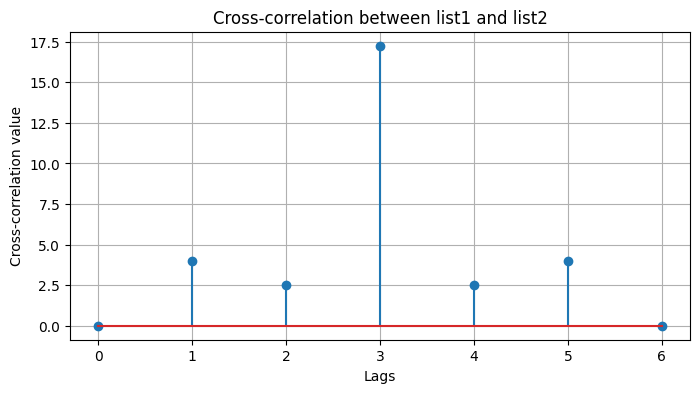

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Define your lists
list1 = [0, 1, 0.5, 4]
list2 = [0, 1, 0.5, 4]

# Compute cross-correlation
cross_corr = np.correlate(list1, list2, mode='full')

# Plotting the cross-correlation
plt.figure(figsize=(8, 4))
plt.stem(range(len(cross_corr)), cross_corr )  # Using stem plot for discrete data #use_line_collection=True
plt.title('Cross-correlation between list1 and list2')
plt.xlabel('Lags')
plt.ylabel('Cross-correlation value')
plt.grid(True)
plt.show()

In [28]:
n1 = sd_raster[0]

385239

In [29]:
pair

[0, 1]